## Modelisation de la propagation du virus covid19.

### Les caractéristique d'une modélisation compartimental pour fréner la pandémie  :

- La modelisation mathématique compartimentale se base sur des variables spatio-emporel: dites compartiments.
- Dnas notre modelisation notre model vas contenir ses 5 compartiements de l'épidémie.
    
    Susceptible - Exposed - Infectious - Recovered

    - (S) personnes sainte.
    - (E) personnes exposés au virus.
    - (I) personnes déja infectées.
    - (R) personnes géuris "recovred".

    la somme des valeurs des compartiement quand à elles donne le nombre de la population total :
    
    S + E + I + R = N

    
    - Le système étant temporel sa représentation vas étre une équation diférentiel.
    

- Modelisation du systèm :

     - Notre systéme dois nous simuler la vitessede propagation de la pandémie c'est donc une dérivation d'équation temporel qui vas contenir le diférences entre les dérivées des compartiements .
        
        Modelisation du système :
        
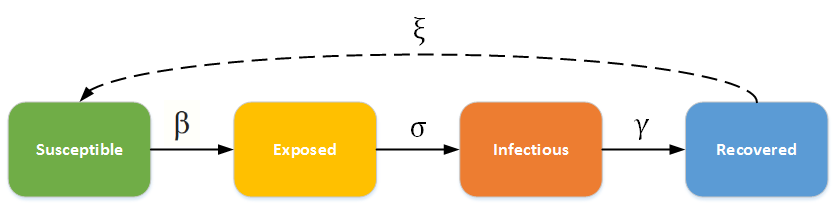
          
      - Equation : N = S + E + I + R
          
          B = taux de transmission.
          O = taux d'incubation.
          G = taux de guérison.
          
          * dS/dt = -B*S*I/N
          * dE/dt = B*S*I/N - O*E              
          * dI/dt = O*E - G*I
          * dR/dt = G*I
  
          équation diférentien/
        
          P = dN(t)/dt = ds(t)/dt + de(t)/dt + di(t)/dt + dr(t)/dt


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

START_DATE = {
  'Japan': '1/22/20',
  'Italy': '1/31/20',
  'Republic of Korea': '1/22/20',
  'Iran (Islamic Republic of)': '2/19/20'
}

class Learner(object):
    def __init__(self, country, loss):
        self.country = country
        self.loss = loss

    def load_confirmed(self, country):
      """
      Load confirmed cases downloaded from HDX
      """
      df = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, rho, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 150
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            E = y[1]
            I = y[2]
            R = y[3]
            return [-beta*S*I, beta*S*I-rho*E, rho*E-gamma*I, gamma*I,]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [S_0,E_0,I_0,R_0], t_eval=np.arange(0, size, 1))

    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        data = self.load_confirmed(self.country)
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(data),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = self.predict(beta, gamma, rho, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'E': prediction.y[1],
            'I': prediction.y[2]
            'E': prediction.y[3]
        }, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        fig.savefig(f"{self.country}.png")